## First, we import the necessary libraries for data manipulation, visualization, and model building. Get ready to see some cool plots and models in action!


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split , GridSearchCV , ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.impute import KNNImputer
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing


## We’ll start by loading the data, cleaning it, and handling missing values using KNN Imputer. Then, we perform feature scaling to make sure our model performs optimally.

In [2]:
data = pd.read_csv("/kaggle/input/titanic/train.csv")
y_train = data["Survived"].values
data["Sex"] = data["Sex"].replace({"male": 0, "female": 1})

data.drop(columns=["PassengerId", "Name", "Ticket", "Cabin", "Embarked", "Survived"], inplace=True)

knn_imp = KNNImputer()
data = pd.DataFrame(knn_imp.fit_transform(data), columns=data.columns)

X_train = data.values


# Test Data Preprocessing


## The test dataset undergoes the same preprocessing as the training data to ensure consistency.

In [3]:
test = pd.read_csv("/kaggle/input/titanic/test.csv")
passenger_ID = test["PassengerId"]
test["Sex"] = test["Sex"].replace({"male": 0, "female": 1})
test.drop(columns=["PassengerId", "Name", "Ticket", "Cabin", "Embarked"], inplace=True)

knn_imp = KNNImputer()
test = pd.DataFrame(knn_imp.fit_transform(test), columns=test.columns)

X_test = test.values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Exploratory Data Analysis (EDA)

## Before jumping into the model, let’s visualize some interesting insights.



### Distribution of Survived vs. Not Survived

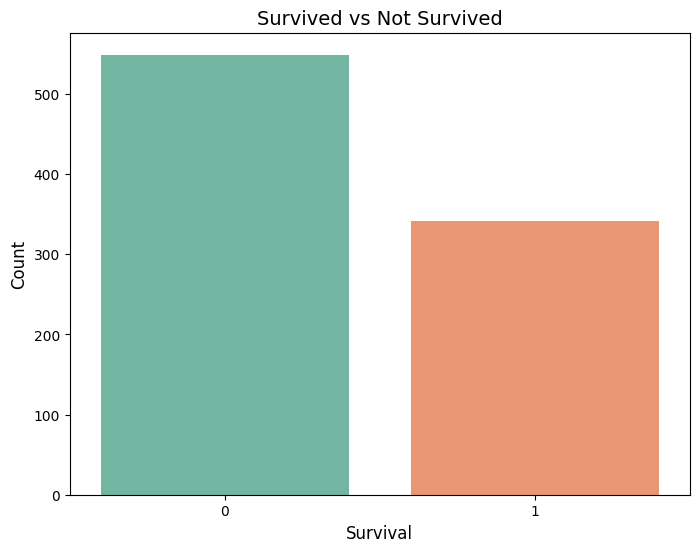

In [4]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train, data=data, palette="Set2")
plt.title("Survived vs Not Survived", fontsize=14)
plt.xlabel("Survival", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

### Age Distribution of Passengers

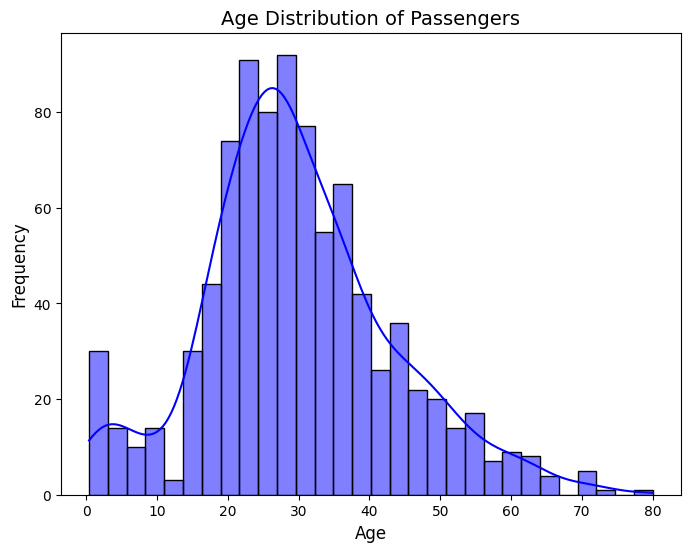

In [5]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Age'], kde=True, color='blue', bins=30)
plt.title("Age Distribution of Passengers", fontsize=14)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

# XGBoost Classifier Model

## Now, let's move on to building the XGBoost model. We’ll fit the model and evaluate it on the training data.

In [6]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

xgb_clf.fit(X_train, y_train)

y_pred_train = xgb_clf.predict(X_train)
print(classification_report(y_train, y_pred_train), "\n --------------------------")


              precision    recall  f1-score   support

           0       0.96      0.99      0.97       549
           1       0.98      0.94      0.96       342

    accuracy                           0.97       891
   macro avg       0.97      0.96      0.97       891
weighted avg       0.97      0.97      0.97       891
 
 --------------------------


# Hyperparameter Tuning with GridSearchCV

## We want to find the best parameters for the model. Let's tune the hyperparameters using GridSearchCV.

In [7]:
cv = ShuffleSplit(5, test_size=0.20, random_state=42)

param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 200, 300]
}

xgb_grid = GridSearchCV(xgb_clf, param_grid=param_grid, scoring="accuracy", return_train_score=True, verbose=0)
xgb_grid.fit(X_train, y_train)
print(xgb_grid.best_params_)
print("Best GridSearchCV Score: ", xgb_grid.best_score_)

best_xgb = xgb_grid.best_estimator_

best_xgb.fit(X_train, y_train)


{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Best GridSearchCV Score:  0.8372857949908983


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

# Model Predictions and Submission

### Once our model is tuned and trained, we can predict on the test dataset and prepare the submission. But achieving a good accuracy on the training data does not guarantee the same performance on the test data. In fact, the test dataset is a more accurate reflection of how well the model generalizes to new, unseen data. 

In [8]:
y_pred = best_xgb.predict(X_test)

output = pd.DataFrame({'PassengerId': passenger_ID, 'Survived': y_pred})

output.to_csv('submission.csv', index=False)


# Visualizing Model Performance

## Let's visualize the importance of features in our final XGBoost model.

### Feature Importance

<Figure size 1000x800 with 0 Axes>

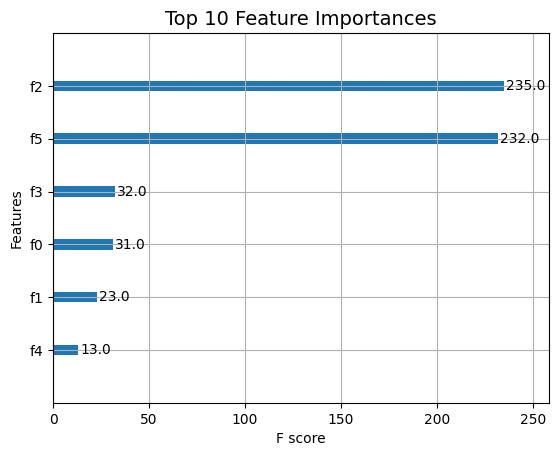

In [9]:
plt.figure(figsize=(10, 8))
xgb.plot_importance(best_xgb, importance_type='weight', max_num_features=10)
plt.title("Top 10 Feature Importances", fontsize=14)
plt.show()

### Confusion Matrix


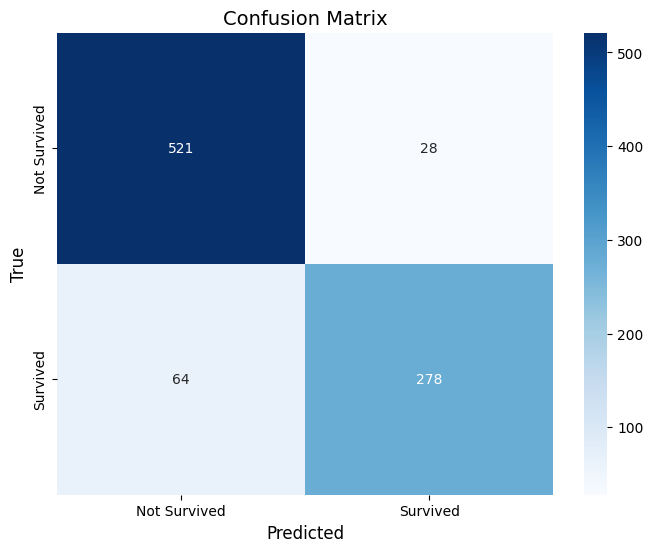

In [10]:
cm = confusion_matrix(y_train, best_xgb.predict(X_train))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Survived", "Survived"], yticklabels=["Not Survived", "Survived"])
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.show()


# Conclusion

### And that’s it! We’ve built a model using XGBoost and improved its performance using hyperparameter tuning. We visualized some cool charts and analyzed our results. You can now download the submission CSV file and submit it.



In [11]:
output.to_csv('submission.csv', index=False)